In [1]:
import pandas as pd
import scipy as sp
import numpy as np

from abtools.bayesian import LognormalABModel

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data.csv')

In [3]:
a = data.query('abgroup == "control"')['sp']
b = data.query('abgroup == "test"')['sp']

print('ARPPU')
print('Mean: %.4f' % a.mean())
print('Mean: %.4f' % b.mean())
print('B больше A на %.4f = %d%%' % (b.mean()- a.mean(), 
                                    (b.mean() / a.mean()-1)*100))

ARPPU
Mean: 20.7789
Mean: 21.3597
B больше A на 0.5808 = 2%


In [6]:
m = (a.mean() + b.mean()) / 2
v = (a.var() + b.var()) / 2

def mu(m, v):
    return np.log(m / np.sqrt(1 + v / (m ** 2)))

def sd(m, v):
    return 1 / np.log(1 + v / (m ** 2))

In [7]:
print(mu(m, v))
print(sd(m, v))

1.62796167804
0.352148646367


In [8]:
model = LognormalABModel(a, b)
model.fit()

         Current function value: 165544.524604
         Iterations: 9
         Function evaluations: 219
         Gradient evaluations: 207


100%|██████████| 10000/10000 [00:11<00:00, 870.42it/s]


In [9]:
model.summary()

,mean,sd,mc_error,hpd_2.5,hpd_97.5
$\mu_{ln(A)}$,1.328479,0.011004,0.000308,1.308089,1.350901
$\mu_{ln(B)}$,1.339023,0.010629,0.000300,1.319226,1.360779
$\tau_A$,0.333594,0.003052,0.000075,0.327316,0.339272
$\tau_B$,0.333422,0.003072,0.000080,0.327650,0.339751
$\mu_A$,16.904586,0.297040,0.007513,16.353505,17.508670
$\mu_B$,17.097009,0.296724,0.007812,16.516910,17.662030
$A_{\sigma^2}$,5.244609,0.115376,0.003226,5.033816,5.483818
$B_{\sigma^2}$,5.356295,0.113970,0.003213,5.147195,5.593240
$\Delta_{\mu}$,0.192423,0.422475,0.011378,-0.637397,0.980716
$\Delta_{\sigma}$,0.024264,0.035556,0.000974,-0.040797,0.097257


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1ecb3b0f0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fc1ea5f72e8>], dtype=object)

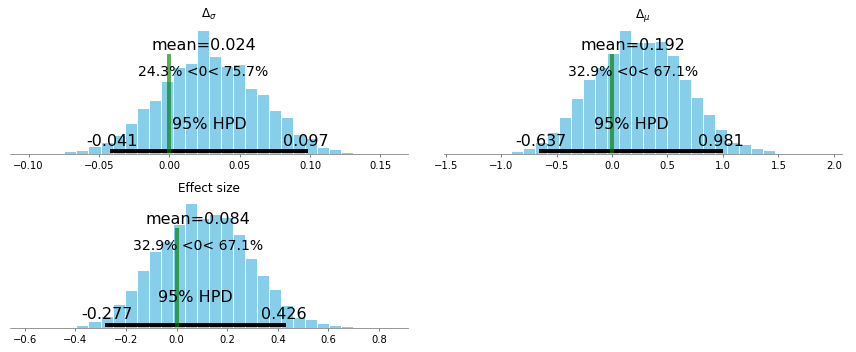

In [10]:
model.plot_deltas()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1ebcf2390>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fc1ecc5a7f0>], dtype=object)

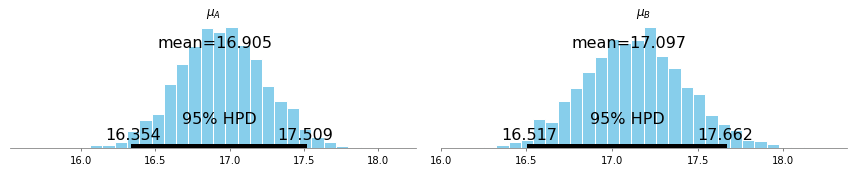

In [11]:
model.plot_params()

In [4]:
from abtools.frequentist import ztest, ttest

In [5]:
ztest(a.sample(frac=0.01), b.sample(frac=0.01))

Fisher's z-test:
--------------------------
	Observed difference of means (E(B) - E(A)) = -4.13
	z-statistic = 0.6585 and z-critical = 1.9600
	A group's mean 95% confidence interval = [13.90, 32.13]
	B group's mean 95% confidence interval = [10.58, 27.18]
	Two-sided p-value = 0.510189617745
	Null hypotesis is not rejected
	E(A) = E(B)


(0.51018961774470317, False, 'E(A) = E(B)')

In [6]:
ttest(a.sample(frac=0.01), b.sample(frac=0.01))

Student's unpaired t-test:
--------------------------
	Observed difference of means (E(B) - E(A)) = 3.22
	t-statistic = -0.5115 and t-critical = 1.9668
	A group's mean 95% confidence interval = [11.45, 21.80]
	B group's mean 95% confidence interval = [8.58, 31.12]
	Two-sided p-value = 0.609312684397
	Null hypotesis is not rejected
	E(A) = E(B)


(0.60931268439706698, False, 'E(A) = E(B)')